In [4]:
%load_ext google.cloud.bigquery

import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import shape, Point, LineString, Polygon
%matplotlib inline
#ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11.4'

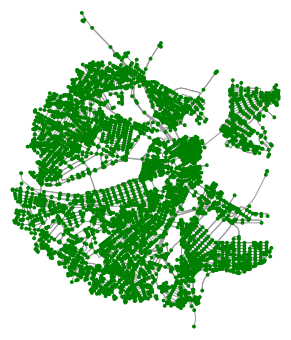

In [2]:
# create the street network within the area (42.35817°N 71.06369°W)
location_point = (42.35817, -71.06369)
G = ox.graph_from_point(location_point, distance=5000, distance_type='network', network_type='drive', simplify=False)
#G = ox.graph_from_place('Boston, Massachusetts, USA', network_type='drive', simplify=False)
G = ox.project_graph(G)
# simplify network with strict mode turned on
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='g', node_zorder=3)

In [5]:
%%bigquery
SELECT st_asgeojson(geometry) AS coord
    #road_geom.xy as line
FROM `bigquery-public-data.geo_openstreetmap.planet_nodes`
    WHERE STRUCT("highway", "motorway") in UNNEST(all_tags) or STRUCT("highway", "motorway_junction") in UNNEST(all_tags)
#     .key = highway and all_tags.value = motorway
#     SELECT
        
#     FROM all_tags
LIMIT 100

,coord
0,"{ ""type"": ""Point"", ""coordinates"": [5.0293197, ..."
1,"{ ""type"": ""Point"", ""coordinates"": [3.111607099..."
2,"{ ""type"": ""Point"", ""coordinates"": [-81.5521299..."
3,"{ ""type"": ""Point"", ""coordinates"": [-122.272269..."
4,"{ ""type"": ""Point"", ""coordinates"": [121.0192498..."
...,...
95,"{ ""type"": ""Point"", ""coordinates"": [-118.347361..."
96,"{ ""type"": ""Point"", ""coordinates"": [-94.1700388..."
97,"{ ""type"": ""Point"", ""coordinates"": [-93.3999190..."
98,"{ ""type"": ""Point"", ""coordinates"": [-65.8357157..."


In [8]:
from google.cloud import bigquery
client = bigquery.Client()

sql = """
    SELECT
        *
    FROM `bigquery-public-data.geo_openstreetmap.planet_nodes`
        WHERE STRUCT("highway", "motorway") in UNNEST(all_tags) or STRUCT("highway", "motorway_junction") in UNNEST(all_tags)
    LIMIT 100
"""

df = client.query(sql).to_dataframe()

df

,id,version,username,changeset,visible,osm_timestamp,geometry,all_tags
0,2086825,10,Sovxx,66365698,True,2019-01-16 14:46:06+00:00,POINT(5.03559860000008 45.8359281),"[{'key': 'noref', 'value': 'yes'}, {'key': 'na..."
1,227474179,9,Stephen214,56913041,True,2018-03-05 19:14:23+00:00,POINT(-97.4691389000001 27.7786735000002),"[{'key': 'noref', 'value': 'yes'}, {'key': 'hi..."
2,118533112,6,ELadner,23120645,True,2014-06-24 11:52:27+00:00,POINT(-90.7904894999997 35.0364354999996),"[{'key': 'ref', 'value': '241A'}, {'key': 'hig..."
3,29961253,6,Emilio Gomez,12613335,True,2012-08-04 19:30:17+00:00,POINT(-4.73669959999992 41.0812028999997),"[{'key': 'ref', 'value': '129'}, {'key': 'exit..."
4,367779350,12,StellanL,3556308,True,2010-01-06 19:27:32+00:00,POINT(-120.2143978 37.0952229999999),"[{'key': 'ref', 'value': '167'}, {'key': 'high..."
...,...,...,...,...,...,...,...,...
95,1833324204,2,greecemapper,29318467,True,2015-03-07 22:18:43+00:00,POINT(110.2904508 39.6786829999999),"[{'key': 'highway', 'value': 'motorway_junctio..."
96,2797854928,2,miko101,36637811,True,2016-01-17 17:25:20+00:00,POINT(16.7379595 52.4435853000003),"[{'key': 'milestone', 'value': '145'}, {'key':..."
97,1957875373,2,greecemapper,25314504,True,2014-09-08 19:17:16+00:00,POINT(112.9887063 22.6614720000019),"[{'key': 'highway', 'value': 'motorway_junctio..."
98,2341070882,2,Ido Marom,42333104,True,2016-09-21 20:27:48+00:00,POINT(30.9500925 -25.4380617000025),"[{'key': 'ref', 'value': '325'}, {'key': 'name..."


In [64]:
type(df.geometry[0])

str

In [86]:
sql1 = """
    SELECT
        st_asgeojson(geometry) AS coord
    FROM `bigquery-public-data.geo_openstreetmap.planet_nodes`
        WHERE STRUCT("highway", "motorway") in UNNEST(all_tags) or STRUCT("highway", "motorway_junction") in UNNEST(all_tags)
    LIMIT 10000
    """

#     DECLARE @InputQuery NVARCHAR(2000) = N'
#     SELECT AS coord
#     FROM `bigquery-public-data.geo_openstreetmap.planet_nodes`
#         WHERE STRUCT("highway", "motorway") in UNNEST(all_tags) or STRUCT("highway", "motorway_junction") in UNNEST(all_tags)
#     LIMIT 100
#     a(n)
#     '
#     EXEC sp_execute_external_script 
#     @language =N'Python',
#     @script=N'
#     from shapely.geometry import Point
#     OutputDataSet = Point(eval(InputDataSet['coord'])['coordinates'])', 
#     @input_data_1 = @InputQuery

points = client.query(sql1).to_dataframe()

points

,coord
0,"{ ""type"": ""Point"", ""coordinates"": [5.035598600..."
1,"{ ""type"": ""Point"", ""coordinates"": [-97.4691389..."
2,"{ ""type"": ""Point"", ""coordinates"": [-90.7904894..."
3,"{ ""type"": ""Point"", ""coordinates"": [-4.73669959..."
4,"{ ""type"": ""Point"", ""coordinates"": [-120.214397..."
...,...
9995,"{ ""type"": ""Point"", ""coordinates"": [-74.2871067..."
9996,"{ ""type"": ""Point"", ""coordinates"": [18.3716003,..."
9997,"{ ""type"": ""Point"", ""coordinates"": [-87.8254899..."
9998,"{ ""type"": ""Point"", ""coordinates"": [-89.4951147..."


In [67]:
points.coord[0]

'{ "type": "Point", "coordinates": [5.03559860000008, 45.8359281] } '

In [74]:
for index, row in points.iterrows():
    print(type(Point(eval(row['coord'])['coordinates'])))
    #print(Point(row['coord']['coordinates']))

<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.

In [87]:
geom = []
for index, row in points.iterrows():
    geom.append(Point(eval(row['coord'])['coordinates']))

gdf = gpd.GeoDataFrame({'geometry':geom})

#gdf = gpd.GeoDataFrame(df)
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [81]:

gdf.geometry.name

'geometry'

In [82]:
gdf.geometry

0        POINT (5.03560 45.83593)
1      POINT (-97.46914 27.77867)
2      POINT (-90.79049 35.03644)
3       POINT (-4.73670 41.08120)
4     POINT (-120.21440 37.09522)
                 ...             
95     POINT (114.09849 22.67899)
96     POINT (140.74799 36.90115)
97      POINT (-8.54400 41.23706)
98       POINT (8.87664 49.24366)
99      POINT (-7.94998 41.47413)
Name: geometry, Length: 100, dtype: geometry

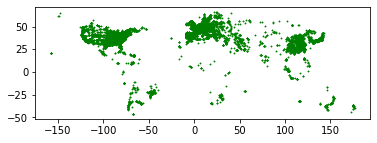

In [89]:
gdf.plot(marker='*', color='green', markersize=1)